In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data_med/'
batch_size = 256
batch_num  = 128
epoch_num  = 200
samp_num   = 7

device = torch.device("cuda:1")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [4]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    sampn = min(len(papers[_time]), batch_size)
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), sampn, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
            edge[x_id][fids.index(f_id)] = True
    pids = np.stack([pids, np.repeat([_time], sampn)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list, _ = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'venue': fids}, sampled_depth = 3, sampled_number = 100)

    el = []
    for i in edge_list['paper']['venue']['rev_PV_Journal']:
        if i[0] in edge and i[1] in edge[i[0]]:
            continue
        el += [i]
    edge_list['paper']['venue']['rev_PV_Journal'] = el

    el = []
    for i in edge_list['venue']['paper']['PV_Journal']:
        if i[1] in edge and i[0] in edge[i[1]]:
            continue
        el += [i]
    edge_list['venue']['paper']['PV_Journal'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list, graph)
    '''
        Trace the paper_id and venue_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    venue_ids = np.arange(len(fids)) + node_dict['venue'][0]
    ylabel = torch.zeros(sampn, len(cand_list))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][cand_list.index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [5]:
class RAGCNConv(MessagePassing):
    def __init__(self, in_dim, out_dim, num_types, num_relations, n_heads, dropout = 0.3, **kwargs):
        super(RAGCNConv, self).__init__(aggr='add', **kwargs)

        self.in_dim        = in_dim
        self.out_dim       = out_dim
        self.num_types     = num_types
        self.num_relations = num_relations
        self.total_rel     = num_types * num_relations * num_types
        self.n_heads       = n_heads
        self.d_k           = out_dim // n_heads
        self.sqrt_dk       = math.sqrt(self.d_k)
        self.att           = None
        
        self.interact_sws   = nn.ModuleList()
        self.interact_tws   = nn.ModuleList()
        self.transfer_sws   = nn.ModuleList()
        
        self.relation_ws   = nn.ModuleList()
        self.aggregat_ws   = nn.ModuleList()
        self.norms         = nn.ModuleList()
        
        for t in range(num_types):
            self.interact_sws.append(nn.Linear(in_dim,   out_dim))
            self.interact_tws.append(nn.Linear(in_dim,   out_dim))
            self.transfer_sws.append(nn.Linear(in_dim,   out_dim))
            self.aggregat_ws.append(nn.Linear(out_dim,  out_dim))
            self.norms.append(BatchNorm(out_dim))
            
        self.relation_ws   = nn.Parameter(torch.ones(num_types, num_relations, num_types, self.n_heads))
        self.interact_rw   = nn.Parameter(torch.Tensor(num_relations, n_heads, self.d_k, self.d_k))
        self.transfer_rw   = nn.Parameter(torch.Tensor(num_relations, n_heads, self.d_k, self.d_k))
        
        self.drop          = nn.Dropout(dropout)
        self.emb           = RelTemporalEncoding(in_dim)
        
        glorot(self.interact_rw)
        glorot(self.transfer_rw)
        
    def forward(self, node_inp, node_type, edge_index, edge_type, edge_time):
        return self.propagate(edge_index, node_inp=node_inp, node_type=node_type, \
                              edge_type=edge_type, edge_time = edge_time)

    def message(self, edge_index_i, node_inp_i, node_inp_j, node_type_i, node_type_j, edge_type, edge_time, num_nodes):
        '''
            i: target; j: source
        '''
        data_size = edge_index_i.size(0)
        atts, vals = [], []
        res_att     = torch.zeros(data_size, self.n_heads).to(node_inp_i.device)
        res_val     = torch.zeros(data_size, self.n_heads, self.d_k).to(node_inp_i.device)
        
        for source_id in range(self.num_types):
            sb = node_type_j == source_id
            interact_sw = self.interact_sws[source_id]
            transfer_sw = self.transfer_sws[source_id]
            for target_id in range(self.num_types):
                tb = (node_type_i == target_id) & sb
                interact_tw = self.interact_tws[target_id]
                for relation_id in range(self.num_relations):
                    idx = tb & (edge_type == relation_id)
                    if idx.sum() == 0:
                        continue
                    _node_inp_i = node_inp_i[idx]
                    _node_inp_j = node_inp_j[idx]
#                     _node_inp_j = self.emb(node_inp_j[idx], edge_time[idx])
                    
                    _int_i = interact_tw(_node_inp_i).view(-1, self.n_heads, self.d_k)
                    _int_j = interact_sw(_node_inp_j).view(-1, self.n_heads, self.d_k)
                    
                    _int_s = torch.bmm(_int_j.transpose(1,0), self.interact_rw[relation_id]).transpose(1,0)
                    res_att[idx] = (_int_s * _int_i).sum(dim=-1) * self.relation_ws[target_id][relation_id][source_id] / self.sqrt_dk
                    
                    _tra_j = transfer_sw(_node_inp_j).view(-1, self.n_heads, self.d_k)
                    res_val[idx] = torch.bmm(_tra_j.transpose(1,0), self.transfer_rw[relation_id]).transpose(1,0)
                    
        self.att = softmax(res_att, edge_index_i, data_size)
        res = res_val * self.att.view(-1, self.n_heads, 1)
        del res_att, res_val
        return res.view(-1, self.out_dim)


    def update(self, aggr_out, node_inp, node_type):
        '''
           x = BN[node_type](W[node_type] * GNN(x) + x)
        '''
        res = torch.zeros(aggr_out.size(0), self.out_dim).to(node_inp.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            norm = self.norms[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = norm(F.relu(aggregat_w(aggr_out[idx])) + node_inp[idx])
        out = self.drop(res)
        del res
        return out

    def __repr__(self):
        return '{}(in_dim={}, out_dim={}, num_types={}, num_types={})'.format(
            self.__class__.__name__, self.in_dim, self.out_dim,
            self.num_types, self.num_relations)

In [6]:
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(RAGCNConv(n_hid, n_hid, num_types, num_relations, n_heads, dropout))
    def set_device(self, device):
        self.device = device
        for gc in self.gcs:
            gc.device = device
    def forward(self, node_feature, node_type, edge_time, edge_index, edge_type):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = gc(meta_xs, node_type, edge_index, edge_type, edge_time)
        return meta_xs

In [7]:
'''
Paper-Venue
'''
paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in graph.edge_list['venue']['paper']['PV_Journal']:
    for p_id in graph.edge_list['venue']['paper']['PV_Journal'][f_id]:
        _time = graph.edge_list['venue']['paper']['PV_Journal'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size // 2:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size // 2:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size // 2:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))

In [8]:
types = graph.get_types()
cand_list = list(graph.edge_list['venue']['paper']['PV_Journal'])
gnn = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, num_types = len(types), \
          num_relations = len(graph.get_meta_graph()) + 1, n_heads = 8, n_layers = 3).to(device)
# gnn = torch.load('../pre-train/save/cpc_model.pt').to(device)
classifier = Classifier(256, len(cand_list)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

In [9]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 1500
best_val   = 0
res = []
criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(epoch_num)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    model.train()
    train_losses = []
    torch.cuda.empty_cache()
    for batch in np.arange(2):
        for node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            torch.cuda.empty_cache()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
            del res, loss
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/rgt_1.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        del res, loss
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
            res  = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print(test_ndcg)
            del res
    del train_data, valid_data

Data Preparation: 272.9s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 (217.1s)  LR: 0.00060 Train Loss: 7.73  Valid Loss: 8.50  Valid NDCG: 0.1189
Data Preparation: 57.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 (210.0s)  LR: 0.00069 Train Loss: 5.72  Valid Loss: 8.13  Valid NDCG: 0.1506
Data Preparation: 65.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 3 (215.1s)  LR: 0.00078 Train Loss: 4.44  Valid Loss: 7.48  Valid NDCG: 0.1779
Data Preparation: 51.7s
Epoch: 4 (206.8s)  LR: 0.00085 Train Loss: 4.52  Valid Loss: 7.72  Valid NDCG: 0.1662
Data Preparation: 71.1s
Epoch: 5 (219.9s)  LR: 0.00091 Train Loss: 3.11  Valid Loss: 7.68  Valid NDCG: 0.1625
0.1790160990170712
Data Preparation: 61.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 6 (217.7s)  LR: 0.00096 Train Loss: 3.29  Valid Loss: 7.01  Valid NDCG: 0.2257
Data Preparation: 58.4s
Epoch: 7 (224.7s)  LR: 0.00099 Train Loss: 3.02  Valid Loss: 7.25  Valid NDCG: 0.2025
Data Preparation: 47.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 8 (256.1s)  LR: 0.00100 Train Loss: 3.07  Valid Loss: 6.48  Valid NDCG: 0.2446
Data Preparation: 20.6s
Epoch: 9 (255.3s)  LR: 0.00099 Train Loss: 3.22  Valid Loss: 6.72  Valid NDCG: 0.2393
Data Preparation: 23.3s
Epoch: 10 (252.9s)  LR: 0.00096 Train Loss: 2.71  Valid Loss: 7.18  Valid NDCG: 0.2061
0.2616166306915295
Data Preparation: 32.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 (261.8s)  LR: 0.00092 Train Loss: 2.28  Valid Loss: 6.49  Valid NDCG: 0.2601
Data Preparation: 23.1s
Epoch: 12 (258.7s)  LR: 0.00086 Train Loss: 2.48  Valid Loss: 6.86  Valid NDCG: 0.2527
Data Preparation: 24.0s
Epoch: 13 (251.3s)  LR: 0.00079 Train Loss: 3.06  Valid Loss: 6.75  Valid NDCG: 0.2458
Data Preparation: 30.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 14 (259.1s)  LR: 0.00070 Train Loss: 1.89  Valid Loss: 6.53  Valid NDCG: 0.2834
Data Preparation: 24.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 15 (259.5s)  LR: 0.00061 Train Loss: 2.35  Valid Loss: 5.88  Valid NDCG: 0.3356
0.2896940202871213
Data Preparation: 29.5s
Epoch: 16 (254.0s)  LR: 0.00051 Train Loss: 2.08  Valid Loss: 6.31  Valid NDCG: 0.2975
Data Preparation: 24.1s
Epoch: 17 (251.4s)  LR: 0.00042 Train Loss: 2.74  Valid Loss: 6.67  Valid NDCG: 0.2726
Data Preparation: 32.3s
Epoch: 18 (262.0s)  LR: 0.00032 Train Loss: 1.75  Valid Loss: 6.62  Valid NDCG: 0.2806
Data Preparation: 23.3s
Epoch: 19 (260.4s)  LR: 0.00024 Train Loss: 2.03  Valid Loss: 6.56  Valid NDCG: 0.2717
Data Preparation: 23.1s
Epoch: 20 (250.3s)  LR: 0.00016 Train Loss: 2.54  Valid Loss: 6.78  Valid NDCG: 0.2518
0.3111282140164797
Data Preparation: 34.0s
Epoch: 21 (257.4s)  LR: 0.00009 Train Loss: 1.99  Valid Loss: 6.23  Valid NDCG: 0.3274
Data Preparation: 25.8s
Epoch: 22 (256.8s)  LR: 0.00005 Train Loss: 1.90  Valid Loss: 6.36  Valid NDCG: 0.3054
Data Preparation: 24.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 23 (254.7s)  LR: 0.00001 Train Loss: 1.96  Valid Loss: 5.85  Valid NDCG: 0.3458
Data Preparation: 29.5s
Epoch: 24 (249.7s)  LR: 0.00000 Train Loss: 2.42  Valid Loss: 6.20  Valid NDCG: 0.3028
Data Preparation: 39.2s
Epoch: 25 (256.3s)  LR: 0.00001 Train Loss: 2.04  Valid Loss: 6.03  Valid NDCG: 0.3277
0.3270140384436338
Data Preparation: 28.3s
Epoch: 26 (251.4s)  LR: 0.00003 Train Loss: 2.45  Valid Loss: 6.29  Valid NDCG: 0.3038
Data Preparation: 31.2s
Epoch: 27 (248.7s)  LR: 0.00007 Train Loss: 2.61  Valid Loss: 6.39  Valid NDCG: 0.2845
Data Preparation: 34.9s
Epoch: 28 (249.3s)  LR: 0.00013 Train Loss: 2.44  Valid Loss: 6.27  Valid NDCG: 0.2834
Data Preparation: 33.0s
Epoch: 29 (250.2s)  LR: 0.00020 Train Loss: 2.24  Valid Loss: 6.65  Valid NDCG: 0.2689
Data Preparation: 30.3s
Epoch: 30 (254.1s)  LR: 0.00029 Train Loss: 2.16  Valid Loss: 5.92  Valid NDCG: 0.3260
0.34650422572458
Data Preparation: 29.9s
Epoch: 31 (251.6s)  LR: 0.00038 Train Loss: 2.38  Valid Loss: 6.14  Valid ND

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 32 (254.4s)  LR: 0.00048 Train Loss: 2.14  Valid Loss: 5.86  Valid NDCG: 0.3474
Data Preparation: 22.4s
Epoch: 33 (245.5s)  LR: 0.00057 Train Loss: 2.46  Valid Loss: 6.35  Valid NDCG: 0.3046
Data Preparation: 35.7s
Epoch: 34 (253.3s)  LR: 0.00067 Train Loss: 2.12  Valid Loss: 5.86  Valid NDCG: 0.3123
Data Preparation: 28.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 35 (254.9s)  LR: 0.00075 Train Loss: 2.17  Valid Loss: 5.96  Valid NDCG: 0.3526
0.35980236260291687
Data Preparation: 28.1s
Epoch: 36 (249.6s)  LR: 0.00083 Train Loss: 2.52  Valid Loss: 6.23  Valid NDCG: 0.2812
Data Preparation: 27.4s
Epoch: 37 (247.2s)  LR: 0.00090 Train Loss: 2.36  Valid Loss: 6.55  Valid NDCG: 0.2745
Data Preparation: 37.7s
Epoch: 38 (249.4s)  LR: 0.00095 Train Loss: 2.07  Valid Loss: 6.07  Valid NDCG: 0.3111
Data Preparation: 31.0s
Epoch: 39 (265.7s)  LR: 0.00098 Train Loss: 1.80  Valid Loss: 5.76  Valid NDCG: 0.3172
Data Preparation: 19.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 40 (255.8s)  LR: 0.00100 Train Loss: 2.05  Valid Loss: 5.37  Valid NDCG: 0.3873
0.3910149291127679
Data Preparation: 28.3s
Epoch: 41 (251.2s)  LR: 0.00100 Train Loss: 2.12  Valid Loss: 6.32  Valid NDCG: 0.3036
Data Preparation: 31.2s
Epoch: 42 (256.5s)  LR: 0.00097 Train Loss: 1.58  Valid Loss: 5.66  Valid NDCG: 0.3381
Data Preparation: 33.5s
Epoch: 43 (249.5s)  LR: 0.00093 Train Loss: 1.94  Valid Loss: 5.59  Valid NDCG: 0.3684
Data Preparation: 42.6s
Epoch: 44 (257.4s)  LR: 0.00088 Train Loss: 1.58  Valid Loss: 5.72  Valid NDCG: 0.3579
Data Preparation: 24.6s
Epoch: 45 (250.7s)  LR: 0.00081 Train Loss: 1.87  Valid Loss: 5.50  Valid NDCG: 0.3661
0.38636883715887405
Data Preparation: 35.8s
Epoch: 46 (254.5s)  LR: 0.00072 Train Loss: 1.73  Valid Loss: 5.96  Valid NDCG: 0.3721
Data Preparation: 33.2s
Epoch: 47 (251.3s)  LR: 0.00063 Train Loss: 2.06  Valid Loss: 5.73  Valid NDCG: 0.3780
Data Preparation: 33.8s
Epoch: 48 (252.2s)  LR: 0.00054 Train Loss: 1.81  Valid Loss: 6.01  Valid

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 58 (249.7s)  LR: 0.00002 Train Loss: 1.56  Valid Loss: 5.40  Valid NDCG: 0.4065
Data Preparation: 33.2s
Epoch: 59 (253.1s)  LR: 0.00006 Train Loss: 1.76  Valid Loss: 5.59  Valid NDCG: 0.3747
Data Preparation: 28.3s
Epoch: 60 (256.2s)  LR: 0.00012 Train Loss: 1.87  Valid Loss: 5.26  Valid NDCG: 0.4036
0.42164025953088435
Data Preparation: 50.6s
Epoch: 61 (250.1s)  LR: 0.00018 Train Loss: 1.69  Valid Loss: 5.71  Valid NDCG: 0.3565
Data Preparation: 5.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 62 (254.3s)  LR: 0.00027 Train Loss: 1.45  Valid Loss: 5.54  Valid NDCG: 0.4265
Data Preparation: 5.5s
Epoch: 63 (256.4s)  LR: 0.00036 Train Loss: 1.59  Valid Loss: 5.81  Valid NDCG: 0.3809
Data Preparation: 6.0s
Epoch: 64 (258.4s)  LR: 0.00045 Train Loss: 1.28  Valid Loss: 5.52  Valid NDCG: 0.3715
Data Preparation: 5.5s
Epoch: 65 (249.7s)  LR: 0.00055 Train Loss: 1.75  Valid Loss: 6.00  Valid NDCG: 0.3425
0.46944043155095605
Data Preparation: 28.2s
Epoch: 66 (254.4s)  LR: 0.00064 Train Loss: 1.68  Valid Loss: 5.39  Valid NDCG: 0.3895
Data Preparation: 5.6s
Epoch: 67 (254.9s)  LR: 0.00073 Train Loss: 1.43  Valid Loss: 5.24  Valid NDCG: 0.4022
Data Preparation: 5.6s
Epoch: 68 (248.6s)  LR: 0.00081 Train Loss: 1.72  Valid Loss: 5.66  Valid NDCG: 0.3914
Data Preparation: 12.2s
Epoch: 69 (241.4s)  LR: 0.00088 Train Loss: 2.08  Valid Loss: 6.38  Valid NDCG: 0.3545
Data Preparation: 16.4s
Epoch: 70 (253.4s)  LR: 0.00094 Train Loss: 1.52  Valid Loss: 5.62  Valid NDCG: 0.3682
0.41051581

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 72 (248.2s)  LR: 0.00100 Train Loss: 1.85  Valid Loss: 4.84  Valid NDCG: 0.4407
Data Preparation: 13.4s
Epoch: 73 (253.0s)  LR: 0.00100 Train Loss: 1.57  Valid Loss: 5.82  Valid NDCG: 0.3627
Data Preparation: 8.2s
Epoch: 74 (255.3s)  LR: 0.00098 Train Loss: 1.76  Valid Loss: 5.45  Valid NDCG: 0.3837
Data Preparation: 6.1s
Epoch: 75 (243.6s)  LR: 0.00095 Train Loss: 1.96  Valid Loss: 5.34  Valid NDCG: 0.4065
0.4083554697660359
Data Preparation: 28.8s
Epoch: 76 (253.1s)  LR: 0.00089 Train Loss: 1.46  Valid Loss: 6.74  Valid NDCG: 0.3099
Data Preparation: 5.3s
Epoch: 77 (248.1s)  LR: 0.00083 Train Loss: 1.57  Valid Loss: 5.25  Valid NDCG: 0.4117
Data Preparation: 14.0s
Epoch: 78 (249.5s)  LR: 0.00075 Train Loss: 1.71  Valid Loss: 6.12  Valid NDCG: 0.3284
Data Preparation: 9.9s
Epoch: 79 (245.1s)  LR: 0.00066 Train Loss: 1.85  Valid Loss: 5.52  Valid NDCG: 0.3772
Data Preparation: 13.2s
Epoch: 80 (255.4s)  LR: 0.00056 Train Loss: 1.30  Valid Loss: 5.55  Valid NDCG: 0.3537
0.47173023

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 99 (243.8s)  LR: 0.00071 Train Loss: 2.02  Valid Loss: 5.07  Valid NDCG: 0.4448
Data Preparation: 21.3s
Epoch: 100 (251.7s)  LR: 0.00079 Train Loss: 1.29  Valid Loss: 5.23  Valid NDCG: 0.4084
0.42114973842093517
Data Preparation: 28.6s
Epoch: 101 (249.3s)  LR: 0.00087 Train Loss: 1.46  Valid Loss: 5.47  Valid NDCG: 0.4283
Data Preparation: 7.6s
Epoch: 102 (246.8s)  LR: 0.00093 Train Loss: 1.53  Valid Loss: 5.26  Valid NDCG: 0.4059
Data Preparation: 6.1s
Epoch: 103 (249.9s)  LR: 0.00097 Train Loss: 1.57  Valid Loss: 5.73  Valid NDCG: 0.3723
Data Preparation: 8.7s
Epoch: 104 (247.0s)  LR: 0.00099 Train Loss: 1.61  Valid Loss: 5.35  Valid NDCG: 0.3901
Data Preparation: 7.9s
Epoch: 105 (244.3s)  LR: 0.00100 Train Loss: 1.94  Valid Loss: 5.09  Valid NDCG: 0.4199
0.45456766131660564
Data Preparation: 28.2s
Epoch: 106 (246.0s)  LR: 0.00099 Train Loss: 1.75  Valid Loss: 5.03  Valid NDCG: 0.4383
Data Preparation: 36.3s
Epoch: 107 (255.5s)  LR: 0.00096 Train Loss: 1.28  Valid Loss: 5.27  

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 109 (243.0s)  LR: 0.00084 Train Loss: 1.89  Valid Loss: 4.89  Valid NDCG: 0.4603
Data Preparation: 32.5s
Epoch: 110 (250.3s)  LR: 0.00077 Train Loss: 1.52  Valid Loss: 5.30  Valid NDCG: 0.4160
0.5454703460395554
Data Preparation: 28.4s
Epoch: 111 (247.1s)  LR: 0.00068 Train Loss: 1.34  Valid Loss: 6.19  Valid NDCG: 0.3999
Data Preparation: 27.2s
Epoch: 112 (240.5s)  LR: 0.00059 Train Loss: 1.78  Valid Loss: 5.08  Valid NDCG: 0.3992
Data Preparation: 38.5s
Epoch: 113 (245.4s)  LR: 0.00049 Train Loss: 1.50  Valid Loss: 5.10  Valid NDCG: 0.4130
Data Preparation: 35.3s
Epoch: 114 (248.5s)  LR: 0.00039 Train Loss: 1.14  Valid Loss: 5.33  Valid NDCG: 0.4135
Data Preparation: 9.0s
Epoch: 115 (236.8s)  LR: 0.00030 Train Loss: 1.67  Valid Loss: 5.33  Valid NDCG: 0.4317
0.5378890844693132
Data Preparation: 34.5s
Epoch: 116 (245.6s)  LR: 0.00022 Train Loss: 1.42  Valid Loss: 4.91  Valid NDCG: 0.4317
Data Preparation: 37.4s
Epoch: 117 (251.9s)  LR: 0.00014 Train Loss: 1.33  Valid Loss: 4.87

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 119 (243.2s)  LR: 0.00004 Train Loss: 1.51  Valid Loss: 4.69  Valid NDCG: 0.4752
Data Preparation: 42.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 120 (246.5s)  LR: 0.00001 Train Loss: 1.26  Valid Loss: 4.44  Valid NDCG: 0.5194
0.5524685477422646
Data Preparation: 33.0s
Epoch: 121 (242.6s)  LR: 0.00000 Train Loss: 1.56  Valid Loss: 4.97  Valid NDCG: 0.4472
Data Preparation: 31.4s
Epoch: 122 (244.5s)  LR: 0.00001 Train Loss: 1.57  Valid Loss: 4.85  Valid NDCG: 0.4323
Data Preparation: 32.5s
Epoch: 123 (243.0s)  LR: 0.00004 Train Loss: 1.44  Valid Loss: 4.89  Valid NDCG: 0.4551
Data Preparation: 37.9s
Epoch: 124 (248.8s)  LR: 0.00009 Train Loss: 1.40  Valid Loss: 4.85  Valid NDCG: 0.4345
Data Preparation: 28.2s
Epoch: 125 (248.9s)  LR: 0.00015 Train Loss: 1.48  Valid Loss: 4.61  Valid NDCG: 0.4791
0.5082422572041556
Data Preparation: 29.1s
Epoch: 126 (245.8s)  LR: 0.00022 Train Loss: 1.57  Valid Loss: 4.36  Valid NDCG: 0.5159
Data Preparation: 34.3s
Epoch: 127 (248.6s)  LR: 0.00031 Train Loss: 1.43  Valid Loss: 4.67  Valid NDCG: 0.4592
Data Preparation: 32.3s
Epoch: 128 (245.4s)  LR: 0.00040 Train Loss: 1.55  Valid Loss: 4.8

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 146 (240.4s)  LR: 0.00042 Train Loss: 1.70  Valid Loss: 4.18  Valid NDCG: 0.5290
Data Preparation: 40.1s
Epoch: 147 (246.2s)  LR: 0.00033 Train Loss: 1.41  Valid Loss: 4.55  Valid NDCG: 0.5058
Data Preparation: 39.5s
Epoch: 148 (247.4s)  LR: 0.00024 Train Loss: 1.40  Valid Loss: 4.57  Valid NDCG: 0.4883
Data Preparation: 31.6s
Epoch: 149 (249.4s)  LR: 0.00016 Train Loss: 1.27  Valid Loss: 4.90  Valid NDCG: 0.4456
Data Preparation: 33.7s
Epoch: 150 (248.4s)  LR: 0.00010 Train Loss: 1.27  Valid Loss: 5.01  Valid NDCG: 0.4812
0.5309158905617668
Data Preparation: 33.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 151 (252.5s)  LR: 0.00005 Train Loss: 1.32  Valid Loss: 4.04  Valid NDCG: 0.5671
Data Preparation: 30.4s
Epoch: 152 (252.4s)  LR: 0.00002 Train Loss: 1.23  Valid Loss: 5.28  Valid NDCG: 0.3845
Data Preparation: 31.8s
Epoch: 153 (244.5s)  LR: 0.00000 Train Loss: 1.63  Valid Loss: 4.80  Valid NDCG: 0.4930
Data Preparation: 39.7s
Epoch: 154 (247.6s)  LR: 0.00001 Train Loss: 1.19  Valid Loss: 4.61  Valid NDCG: 0.5081
Data Preparation: 32.6s
Epoch: 155 (254.6s)  LR: 0.00003 Train Loss: 0.98  Valid Loss: 5.12  Valid NDCG: 0.4512
0.5171851350722048
Data Preparation: 29.2s
Epoch: 156 (240.7s)  LR: 0.00007 Train Loss: 1.59  Valid Loss: 4.88  Valid NDCG: 0.4613
Data Preparation: 44.0s
Epoch: 157 (253.1s)  LR: 0.00013 Train Loss: 1.30  Valid Loss: 4.95  Valid NDCG: 0.4780
Data Preparation: 25.3s
Epoch: 158 (240.7s)  LR: 0.00020 Train Loss: 1.40  Valid Loss: 4.20  Valid NDCG: 0.5387
Data Preparation: 34.9s
Epoch: 159 (247.7s)  LR: 0.00028 Train Loss: 1.26  Valid Loss: 4.91  Valid NDCG: 0.44

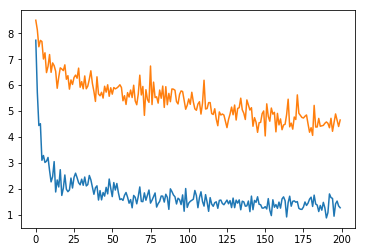

In [10]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [ ]:
print(1)

In [11]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.5578343167745036 0.15839030819782246
0.4339889438037153 0.20014724556195002


In [12]:
best_model = torch.load('./save/rgt_1.pt')

In [14]:
best_model.eval()
gnn, classifier = best_model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.5076243647515813 0.15678021712988516
0.3847016170881379 0.19512317641167734
